# import 

In [1]:
## Import

import os
import scipy.io
import numpy as np
import os, importlib
import matplotlib.pyplot as plt
import statistics
import scipy.stats
import matplotlib.patches as mpatches
import tkinter as tk
import pandas as pd
import pickle
from open_ephys.analysis import Session

# functions

In [2]:
## Functions

def diff(data):
    diff = []
    for i in range(1,len(data)):
        diff = diff + [data[i] - data[i-1]]
    return(diff)

def create_spike_time_vectors(spike_times,clusters):
    spiketimevectors = []
    for i in np.unique(clusters):
        spiketimevectors = spiketimevectors + [spike_times[np.where(clusters==i)[0]]]
    return spiketimevectors

def SaveFig(file_name,figure_dir):
    if os.path.isfile(figure_dir + file_name ):
        os.remove(figure_dir + file_name)  
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name)
    plt.close()
    

def Reformat_PokeEphysTS(PokeIn_EphysTS):
    P1_PokeIn_EphysTS = np.array([])
    P2_PokeIn_EphysTS = np.array([])
    for ind, item in enumerate(PokeIn_EphysTS):
        if ind > 0:
            P1_PokeIn_EphysTS = np.append(P1_PokeIn_EphysTS,[PokeIn_EphysTS[ind-1]])
            
            if item == 'NaN':
                P2_PokeIn_EphysTS = np.append(P2_PokeIn_EphysTS,[np.nan])
            else:
                P2_PokeIn_EphysTS =  np.append(P2_PokeIn_EphysTS,[item])
    return np.array(P1_PokeIn_EphysTS),P2_PokeIn_EphysTS



## new version for new open ephys tools 
def align_open_ephys_processors(main_processor_tuple, aux_processor_tuples, session_path=None, synch_channel=1):

    session_data = Session(str(raw_data_directory))
    if len(session_data.recordnodes) != 1:
        raise ValueError("should be exactly one record node.")
    if len(session_data.recordnodes[0].recordings) != 1:
        raise ValueError("Should be exactly one recording.")
    for rn, recordnode in enumerate(session_data.recordnodes):
        for r, recording in enumerate(recordnode.recordings):
            # Synch
            recording.add_sync_line(
                synch_channel,
                main_processor_tuple[0],
                main_processor_tuple[1],
                main=True,
            )
            for aux_processor in aux_processor_tuples:
                recording.add_sync_line(
                    synch_channel,
                    aux_processor[0],
                    aux_processor[1],
                    main=False,
                )
            print('this should be zero:')
            print(rn)
        
    return recording


def sequence_contains_sequence(haystack_seq, needle_seq, string):
    start_index = []
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            start_index = start_index + [i]
            print(string + ' barcode found')
    return start_index

def find_first_poke_times(trial_id,ports, poke_in_array):

    first_poke_index = []
    count = 1

    for index,item in enumerate(trial_id):
        if item == count:
            if ports[index] == 2:
                count = count + 1
                first_poke_index = first_poke_index + [index]
            
    return poke_in_array[np.array(first_poke_index)]

def align_firstpoke_camera_timestamps(trial_id,Trial_start_ts,All_Port_references_sorted):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == 2.0:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

def align_trial_start_end_timestamps(trial_id,Trial_start_ts):
    trial_ts_aligned = []
    counter = 1
    for index, item in enumerate(trial_id):
        if counter ==  item:
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
        else:
            counter = counter + 1
            trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
    
    return trial_ts_aligned
            

def clock_find_first_poke_times(trial_id,ports, poke_in_array,trial_seqs):

    first_poke_index = []
    count = 1

    for index,item in enumerate(trial_id):
        if item == count:
            if ports[index] == trial_seqs[index][0]:
                count = count + 1
                first_poke_index = first_poke_index + [index]
            
    return poke_in_array[np.array(first_poke_index)]

def clock_align_firstpoke_camera_timestamps(trial_id,Trial_start_ts,All_Port_references_sorted,trial_seqs):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == trial_seqs[index][0]:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned

def AlignToTriggersAndFIndEphysTimestamps(Port_intimes,trial_id,first_poke_times,trial_start,TrialStart_EphysTime,FirstPoke_EphysTime):

    new_TS = []
    for index, trial in enumerate(trial_id):
        if np.isnan(Port_intimes[index]):
            new_TS = new_TS + [np.nan]
        else:

            current_poke_event_time = Port_intimes[index]

            # find ech relevant timestamps
            CurrentTrial_startTS = trial_start[trial-1]
            First_pokeTS = first_poke_times[trial-1]

            # last trial has no next trial start
            if trial == trial_id[-1]:
                NextTrial_startTS = 9999999999999
            else:
                NextTrial_startTS = np.unique(trial_start)[trial]

            # find the ts current poke event is closest to
            trialstart_diff =  abs(CurrentTrial_startTS - current_poke_event_time)

            EphysTS = TrialStart_EphysTime[trial-1]
            current_dist = current_poke_event_time - CurrentTrial_startTS 
            distance = EphysTS + current_dist

            new_TS = new_TS + [distance]
            
    return(new_TS)

def Determine_Transition_Times_and_Types(All_PortIn_Times_sorted ,All_PortOut_Times_sorted, All_Port_references_sorted):
    out_in= []
    in_in = []
    transition_type = []
    out_in_transition_reference = []
    in_in_transition_reference = []
    for index,port in enumerate(All_Port_references_sorted):
        if index > 0:
            out_in = out_in + [All_PortIn_Times_sorted[index] - All_PortOut_Times_sorted[index-1] ]
            out_in_transition_reference = out_in_transition_reference + [All_PortOut_Times_sorted[index-1]]

            in_in = in_in + [All_PortIn_Times_sorted[index] - All_PortIn_Times_sorted[index-1] ]
            in_in_transition_reference = in_in_transition_reference + [All_PortIn_Times_sorted[index-1]]

            transition_type = transition_type + [int(str(All_Port_references_sorted[index-1]) + str(port))]

    return (np.array(out_in),np.array(in_in) ,np.array(transition_type),out_in_transition_reference,in_in_transition_reference)

def Determine_transition_matrix(prev_port,current_port):
    Transition = (prev_port * 10) + current_port
    return Transition

def Start_End_port_id(Transition_types,start_end_arg):
    output = []
    for item in Transition_types:
        String = str(item)
        output = output + [int(String[start_end_arg])]
    return output

def determine_RepeatPort_events(start_port_ids,end_port_ids):
    Port_repeat = []
    for index, item in enumerate(start_port_ids):
        if item == end_port_ids[index]:
            Port_repeat = Port_repeat + [0]
        else: 
            Port_repeat = Port_repeat + [1]
    return Port_repeat    

def filter_transitons_by_latency(Transition_times, Upper_Filter):
    Filtered_transitions = []
    for item in Transition_times:
        if item < Upper_Filter:
            Filtered_transitions = Filtered_transitions + [1]
        else:
            Filtered_transitions = Filtered_transitions + [0]
    return Filtered_transitions

def find_files(filename, search_path):
    result = []

    #Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))

    return result

def find_folder_path(parent_folder, target_folder):
    for root, dirs, files in os.walk(parent_folder):
        if target_folder in dirs:
            return os.path.join(root, target_folder)
        # If the target folder is not found
    return (print('not found'))

# Choose data to process:

In [7]:
probe = 'probeA'
index = 0


#sample rate:
Fs = 30000.0

## gather all raw ephys paths
path_ = r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\"
base_recording_paths = []
for q in os.listdir(path_):
    if not 'other_sessions' in q:
        folder = os.path.join(path_,q)
        for q in os.listdir(folder):
            base_recording_paths+=[os.path.join(folder,q)]
            

# gather the corespoding organised paths for each raw dat file 
organised_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
full_organised_paths = []
for i in range(len(base_recording_paths)):
    mouse_id = base_recording_paths[i].split('\\')[-1].split('_')[0]
    date_ = base_recording_paths[i].split('\\')[-1].split('_')[1]
    #reverse the date
    date_ = '-'.join(date_.split('-')[::-1])
    
    organised_path_animal = os.path.join(organised_path,mouse_id+'_implant1')

    for recording in os.listdir(organised_path_animal):
        if date_ in recording:
            full_organised_paths += [os.path.join(organised_path_animal,recording)]
            break


for index in range(len(base_recording_paths)):
    print(index)
       
    # set important paths 
    raw_data_directory = base_recording_paths[index]
    print(raw_data_directory)
    OE_processor_path = find_folder_path(raw_data_directory, "continuous") 
    Behav_data_path = full_organised_paths[index]+ r'//behav_sync/2_task/Preprocessed//'

    Processed_Ephys_data_path = full_organised_paths[index]+ r'/ephys//' + probe + r'/kilosort4_output/sorter_output//'
    
    organised_ephys_path = full_organised_paths[index]+ r'/ephys//'

    if probe in os.listdir(full_organised_paths[index]+ r'/ephys//'):
        if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + probe):
            print('All good! Data is kilosorted')
            
            print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
            print(raw_data_directory)
            print(OE_processor_path)
            print(Behav_data_path)
            print(Processed_Ephys_data_path)
            break
        else:
            print('data not yet kilosorted, skip!')
    else:
        print('data not yet kilosorted, skip!')
        
        
### add to this... if its already been run then also skip...
    

print(index)





0
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-20_09-00-27_saline
data not yet kilosorted, skip!
1
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-21_09-21-32_ap5_ctb647
data not yet kilosorted, skip!
2
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-25_09-41-07
All good! Data is kilosorted
['probeA']
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-25_09-41-07
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\ap5\ap5R_2024-11-25_09-41-07\Record Node 105\experiment1\recording1\continuous
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording6_25-11-2024//behav_sync/2_task/Preprocessed//
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5R_implant1\recording6_25-11-2024/ephys//probeA/kilosort4_output/sorter_output//
2


# choose which units to keep based on LFP spectral power? 

In [4]:
 ### load in spectral power data and use this to make a decision... 
 
 ## then make spikes files from this
 
 ### then in the rest of this doc make the alignment stuff... 
 
 
 
 
# #### Make spike time vectors: 

# # load in spike data and curation file:
# spike_times = np.load(Processed_Ephys_data_path + 'spike_times.npy')
# spike_times = (np.concatenate(spike_times))/Fs
# clusters = np.load(Processed_Ephys_data_path + 'spike_clusters.npy')

# # Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_group.tsv', sep='\t')

# Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_KSLabel.tsv', sep='\t')

# Sort spike data into vectors that can be rasters. ie. single clusters and all spike times in ephys time 

# create spike time vectors for all clusters, adjus for start time offset:
spiketimevectors = create_spike_time_vectors(spike_times,clusters)

# pull out curation scores for each cluster

# Mscore = list(Manual_Score.loc[:,'group'])
# clusterid = list(Manual_Score.loc[:,'cluster_id'])

# Mscore = list(Manual_Score.loc[:,'KSLabel'])
# clusterid = list(Manual_Score.loc[:,'cluster_id'])


# Sort these by good/bad manual clustering scores
# filter spike vectors by manual curation scores:
# CuratedeSpikeTimeVectors = []
# CuratedSpikeClusterIds= []
# for index,ids in enumerate(clusterid):
#     if Mscore[index] == 'good':
#         ind = np.where(np.unique(clusters) == ids)[0][0]
#         CuratedeSpikeTimeVectors = CuratedeSpikeTimeVectors + [spiketimevectors[ind]]
#         CuratedSpikeClusterIds = CuratedSpikeClusterIds + [ids]
        
# print('Total curated clusters = ' + str(len(CuratedeSpikeTimeVectors)))

## Save out curated spike time clusters:

# if not os.path.isdir(output_path):
#     os.makedirs(output_path)
    
# filename = 'Curated_Cluster-Ids'
# with open(output_path  + '/' + filename, 'wb') as fp:
#     pickle.dump(CuratedSpikeClusterIds,fp)
    
# filename = 'Curated_Cluster-SpikeTimes'
# with open(output_path + '/' + filename, 'wb') as fp:
#     pickle.dump(CuratedeSpikeTimeVectors,fp)

NameError: name 'spike_times' is not defined

# Load in raw ephys data and compute gloabl timestamps 

In [ ]:
import re
count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
        main1_2 = processor.split('.')[-1]
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
        main2_2 = processor.split('.')[-1]
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0])
        main3_2 = processor.split('.')[-1]
    count +=1 

main_processor_tuple=(main1, main1_2)

aux_processor_tuples=((main2,main2_2),(main3,main3_2))


: 

dont run this next cell more than once - its super slow

In [ ]:
############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

### LOAD in data: this could take a few minutes

recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,raw_data_directory)
recording.compute_global_timestamps()


############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

this should be zero:
0
Processor ID: 106, Stream Name: ProbeA-AP, Line: 1 (main sync line))
  First event sample number: 397945
  Last event sample number: 520783093
  Total sync events: 17347
  Sample rate: 30000.0
Processor ID: 106, Stream Name: ProbeA-LFP, Line: 1 (aux sync line))
  First event sample number: 33162
  Last event sample number: 43398591
  Total sync events: 17347
  Scale factor: 12.0
  Actual sample rate: 2500.0
Processor ID: 102, Stream Name: PXIe-6341, Line: 1 (aux sync line))
  First event sample number: 403704
  Last event sample number: 520897833
  Total sync events: 17349
  Scale factor: 0.9997906201166776
  Actual sample rate: 30006.28271197317


In [ ]:
## Extract timestamp data:
events_df= recording.events
# i believe line 2 is the 2nd ttl line which carries the Bpod TTLs to the nidaq
Bpod_NIDAQ_TTLS = events_df[events_df.line == 2]

### sort out offset:
sync_messages_path = find_files("sync_messages.txt",raw_data_directory)[0]
sync = open(sync_messages_path, 'r')
lines = sync.readlines()
for line in lines:
    if 'Neuropix-PXI' in line:
        if 'ProbeA-AP' in line:
            print(line)
            start_time_offset = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset)



Start Time for Neuropix-PXI (106) - ProbeA-AP @ 30000 Hz: 354012

11.8004


behaviour barcode found
behaviour barcode found
presleep barcode found


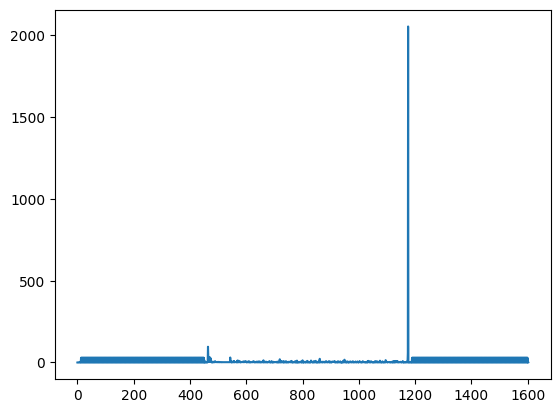

In [76]:
## find barcode indicies: 

Behaviour_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) #LSLSSS (last gap cant be seen as no pulse after it...)
Clock_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 1.0 , 0.05]) # LSLSLS
presleep_barcode = np.array([0.05, 0.5  , 0.05, 0.5 , 0.05, 1.  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) # SSLSSS
postsleep_barcode = np.array([0.05, 1.  , 0.05, 0.5 , 0.05, 0.5  , 0.05, 0.5 , 0.05, 0.5 , 0.05]) # LSSSSS


behaviour_barcode_index = sequence_contains_sequence(list(np.round(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']),2)),list(Behaviour_barcode), 'behaviour')
presleep_barcode_index = sequence_contains_sequence(list(np.round(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']),2)),list(presleep_barcode), 'presleep')
postsleep_barcode_index = behaviour_barcode_index[-1]
behaviour_barcode_index = behaviour_barcode_index[0]
    
plt.plot(np.diff(Bpod_NIDAQ_TTLS['global_timestamp']))
    

In [ ]:
### there should always be a pre and post sleep barcode... but sometimes not a behaviour one.. so instead I need to just work out the point when the first camera ts ends

In [77]:
# load in behavioural data           
Full_Behav_data_path = list(os.walk(Behav_data_path))[-1][0]  
poke_data =  pd.read_csv(Full_Behav_data_path + "/PreProcessed_RawPokeData.csv") 

first_poke_times = find_first_poke_times((poke_data['Trial_id']),list(poke_data['Port']), np.array(poke_data['PokeIn_Time']))
all_timestamps = sorted(list(first_poke_times) + list(np.unique(poke_data['Trial_Start'])))

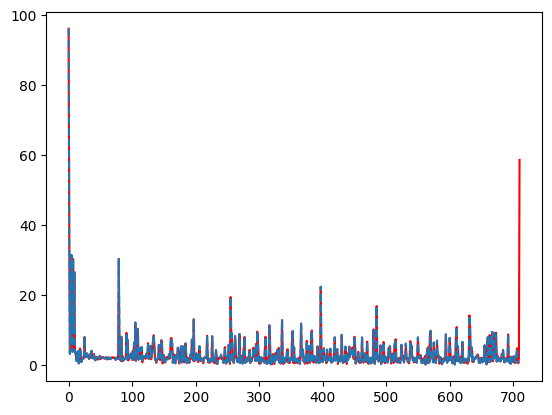

In [89]:

## plot the timestamps (difffernces) to see if they overlay perfectly 
NIDAQ_ts_diff = np.diff(Bpod_NIDAQ_TTLS['global_timestamp'][(behaviour_barcode_index + len(Behaviour_barcode)):postsleep_barcode_index])
behaviour_ts_diff = np.diff(all_timestamps)

plt.plot(NIDAQ_ts_diff[1::], color = 'red') ## 1:: because the behaviour starts from diff between trial and first poke while ephys starts from barcode end to trial start 
plt.plot(behaviour_ts_diff[0::],'--')
# plt.xlim([100, 120])

(-0.1, 0.1)

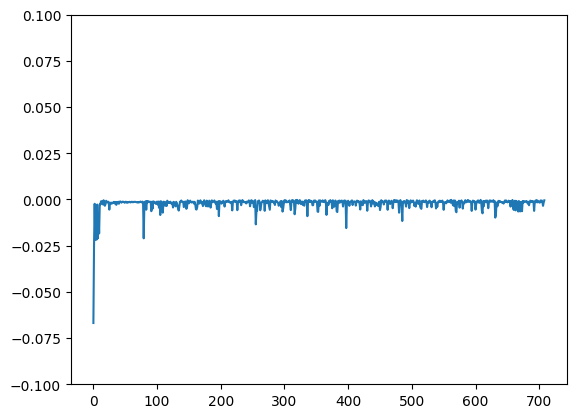

In [91]:
## plot the difference between the two to see if there is misalingment between the two timestamp sets: 
plt.plot(NIDAQ_ts_diff[1:len(all_timestamps)] - behaviour_ts_diff)
plt.ylim([-0.1, 0.1])

In [99]:
## Save this out:

if not os.path.isdir(organised_ephys_path):
    os.makedirs(organised_ephys_path)
save_path = organised_ephys_path + f"global-timstamps_event-df.pkl"
recording.events.to_pickle(save_path)

> Align ephys timestamps and behaviour 

In [101]:
#### align timestamps to behaviour

barcode_offset = (behaviour_barcode_index+ len(Behaviour_barcode))

all_NIDAQ_TS = np.array(Bpod_NIDAQ_TTLS['global_timestamp'][barcode_offset::])

all_states = np.array(Bpod_NIDAQ_TTLS['state'][barcode_offset::])
up_ticks_inds = np.where(all_states == 1)
down_ticks_inds = np.where(all_states == 0)

trial_start_TS = np.unique(poke_data['Trial_Start'])
first_poke_TS = np.array(sorted(list(first_poke_times)))

DO some checks to make sure the timestamps are aligned:

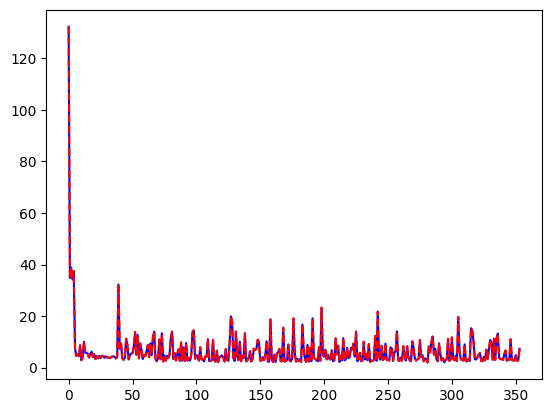

In [102]:
## up ticks - trials start - alignment
aligned_trial_starts_ephys_TS = all_NIDAQ_TS[up_ticks_inds][0:len(trial_start_TS)]

plt.plot(np.diff(aligned_trial_starts_ephys_TS), color = 'blue')
plt.plot(np.diff(trial_start_TS), '--',color = 'red')
# plt.xlim([380, 415])
# plt.xlim([60, 100])

In [103]:
print('start end diffs')
print('for ephys ts:      '+ str(aligned_trial_starts_ephys_TS[-1] - aligned_trial_starts_ephys_TS[0]))
print('for behav ts:      ' + str(trial_start_TS[-1] -  trial_start_TS[0])) 

start end diffs
for ephys ts:      2264.0738122563516
for behav ts:      2265.6466


(-0.1, 0.1)

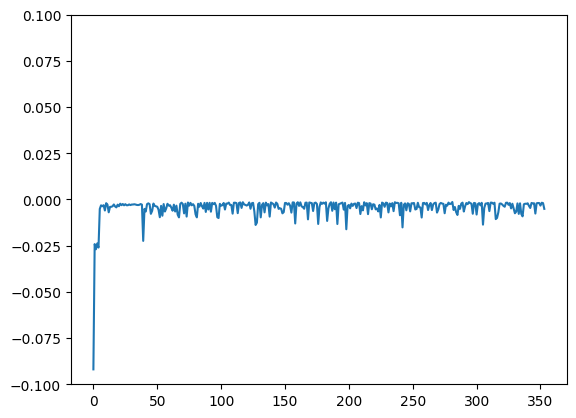

In [119]:
plt.plot(np.diff(aligned_trial_starts_ephys_TS)-np.diff(trial_start_TS))
plt.ylim([-0.1, 0.1])

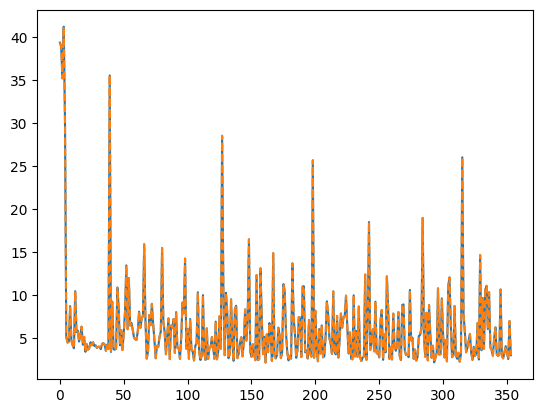

In [111]:
## up ticks - first poke - alignment

aligned_first_poke_ephys_TS = all_NIDAQ_TS[down_ticks_inds][1:len(first_poke_TS)+1]

plt.plot(np.diff(aligned_first_poke_ephys_TS))
plt.plot(np.diff(first_poke_TS),'--')
# plt.xlim([380, 415])
# plt.xlim([0, 40])

(-0.1, 0.1)

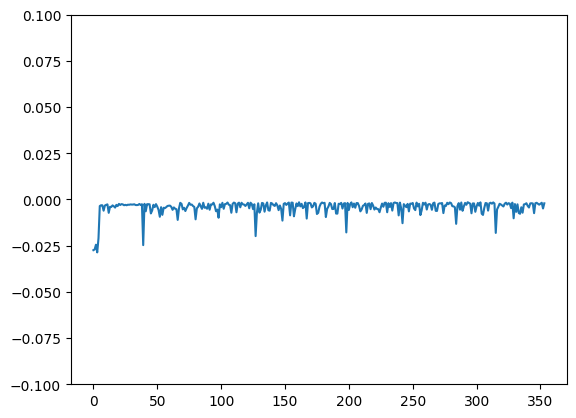

In [112]:
plt.plot(np.diff(aligned_first_poke_ephys_TS)-np.diff(first_poke_TS))
plt.ylim([-0.1, 0.1])

aligne all poke in and out events to nearest ephys trigger

In [113]:
PokeIn_Times = list(poke_data['PokeIn_Time'])
PokeOut_Times = list(poke_data['PokeOut_Time'])
                               
trial_start = list(poke_data['Trial_Start'])
trial_id = list(poke_data['Trial_id'])
                               
PokeInTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeIn_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)
PokeOutTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeOut_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)

In [114]:
## align to and add to dataframe and then save this out: 

df_aligned_firstpoke_ephys_ts = align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS - start_time_offset ,list(poke_data['Port']))

df_aligned_trialstart_ephys_ts = align_trial_start_end_timestamps(list(poke_data['Trial_id']),aligned_trial_starts_ephys_TS)


poke_data['TrialStart_EphysTime'] = np.array(df_aligned_trialstart_ephys_ts) - start_time_offset

poke_data['FirstPoke_EphysTime'] = df_aligned_firstpoke_ephys_ts


## acount for offset 
PokeIN_EphysTime = np.array(PokeInTimes_Ephys_TS) - start_time_offset
PokeOUT_EphysTime = np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset  

## hack if there is a NaN at the end:
PokeOUT_EphysTime = np.append(np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset,'NaN')

poke_data['PokeIN_EphysTime'] = PokeIN_EphysTime
 
poke_data['PokeOUT_EphysTime'] = PokeOUT_EphysTime

poke_data.to_csv(output_path +'/TaskPokeData_camera_ephys_aligned.csv')

KeyboardInterrupt: 

Make transition dataframe

In [1639]:
Port_intimes = list(poke_data['PokeIn_Time'])
Port_outtimes = list(poke_data['PokeOut_Time'])
Ports = list(poke_data['Port'])

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [1640]:
# make dataframe:
Transition_df = pd.DataFrame(
    {'Trial_id' : poke_data['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port 2,3,4,5 LED intensities': poke_data['Port 2,3,4,5 LED intensities'][0:-1],
     'Port 1,2,3,4 RewardAmount':poke_data['Port 1,2,3,4 RewardAmount'][0:-1],
     'Repeat_Filter':Non_Port_repeat,
     'P1_IN_Ephys_TS': PokeIN_EphysTime[0:-1],
     'P1_OUT_Ephys_TS': PokeOUT_EphysTime[0:-1],
     'P2_IN_Ephys_TS': PokeIN_EphysTime[1::],
     'P2_OUT_Ephys_TS': PokeOUT_EphysTime[1::]})
    
#Save Data
Transition_df.to_csv(output_path +'/TaskTransitionData_camera_ephys_aligned.csv')

In [1641]:
poke_data

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,"Port 2,3,4,5 LED intensities","Port 1,2,3,4 RewardAmount",...,SIDE_Trial_End_Camera_Time,SIDE_First_poke_Camera_Time,BOTTOM_Trial_Start_Camera_Time,BOTTOM_Trial_End_Camera_Time,BOTTOM_First_poke_Camera_Time,TrainingLevel,TrialStart_EphysTime,FirstPoke_EphysTime,PokeIN_EphysTime,PokeOUT_EphysTime
0,0,1,14.8383,3,15.2034,15.2907,NaN,21.0427,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,3703.073207,NaN,3703.438307,3703.5256073753117
1,1,1,14.8383,7,15.5255,14.9093,NaN,21.0427,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,3703.073207,NaN,3703.760407,3703.1442073753115
2,2,1,14.8383,1,16.4299,16.5188,NaN,21.0427,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,3703.073207,NaN,3704.664807,3704.7537073753115
3,3,1,14.8383,1,16.6833,16.7577,NaN,21.0427,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,3703.073207,NaN,3704.918207,3704.9926073753118
4,4,1,14.8383,6,17.0839,17.1089,NaN,21.0427,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,3703.073207,NaN,3705.318807,3705.3438073753114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5822,5822,483,4429.5464,6,4441.1958,4441.2289,NaN,4442.5753,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,8117.942557,NaN,8129.591957,8129.625057373588
5823,5823,483,4429.5464,6,4441.2647,4441.3370,NaN,4442.5753,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,8117.942557,NaN,8129.660857,8129.733157373588
5824,5824,483,4429.5464,3,4441.6056,4441.7144,NaN,4442.5753,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,8117.942557,NaN,8130.001757,8130.110557373588
5825,5825,483,4429.5464,3,4441.8660,4441.9494,NaN,4442.5753,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,50,8117.942557,NaN,8130.262157,8130.345557373588


In [1642]:
Transition_df

,Trial_id,Transition_type,Start_Port,End_Port,Start_Poke_in_time,Start_Poke_out_time,End_Poke_in_time,End_Poke_out_time,out_in_Latency,in_in_Latency,2s_Time_Filter_out_in,2s_Time_Filter_in_in,"Port 2,3,4,5 LED intensities","Port 1,2,3,4 RewardAmount",Repeat_Filter,P1_IN_Ephys_TS,P1_OUT_Ephys_TS,P2_IN_Ephys_TS,P2_OUT_Ephys_TS
0,1,37,3,7,15.2034,15.2907,15.5255,14.9093,0.2348,0.3221,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,3703.438307,3703.5256073753117,3703.760407,3703.1442073753115
1,1,71,7,1,15.5255,14.9093,16.4299,16.5188,1.5206,0.9044,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,3703.760407,3703.1442073753115,3704.664807,3704.7537073753115
2,1,11,1,1,16.4299,16.5188,16.6833,16.7577,0.1645,0.2534,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",0,3704.664807,3704.7537073753115,3704.918207,3704.9926073753118
3,1,16,1,6,16.6833,16.7577,17.0839,17.1089,0.3262,0.4006,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,3704.918207,3704.9926073753118,3705.318807,3705.3438073753114
4,1,62,6,2,17.0839,17.1089,17.7569,17.8602,0.6480,0.6730,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,3705.318807,3705.3438073753114,3705.991807,3706.0951073753117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,483,16,1,6,4440.7763,4440.8756,4441.1958,4441.2289,0.3202,0.4195,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,8129.172457,8129.271757373588,8129.591957,8129.625057373588
5822,483,66,6,6,4441.1958,4441.2289,4441.2647,4441.3370,0.0358,0.0689,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",0,8129.591957,8129.625057373588,8129.660857,8129.733157373588
5823,483,63,6,3,4441.2647,4441.3370,4441.6056,4441.7144,0.2686,0.3409,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,8129.660857,8129.733157373588,8130.001757,8130.110557373588
5824,483,33,3,3,4441.6056,4441.7144,4441.8660,4441.9494,0.1516,0.2604,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",0,8130.001757,8130.110557373588,8130.262157,8130.345557373588


# Do the same for the clock task:

In [1601]:
import ast
clock_data =  pd.read_csv(Behav_data_path +'/CLOCK' + "/PreProcessed_RawPokeData.csv") 

trial_seqs = []
for item in list(clock_data['Trial_sequence']):
    trial_seqs = trial_seqs + [ast.literal_eval(item)]

clock_first_poke_times = clock_find_first_poke_times((clock_data['Trial_id']),list(clock_data['Port']), np.array(clock_data['PokeIn_Time']),trial_seqs)
all_timestamps = sorted(list(clock_first_poke_times) + list(np.unique(clock_data['Trial_Start'])))

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\projects\\sequence_squad\\data\\processed_bpod_data\\\\EJT262\\Preprocessed\\02_20230518_124843_Thu/CLOCK/PreProcessed_RawPokeData.csv'

DO some checks to make sure the timestamps are aligned:

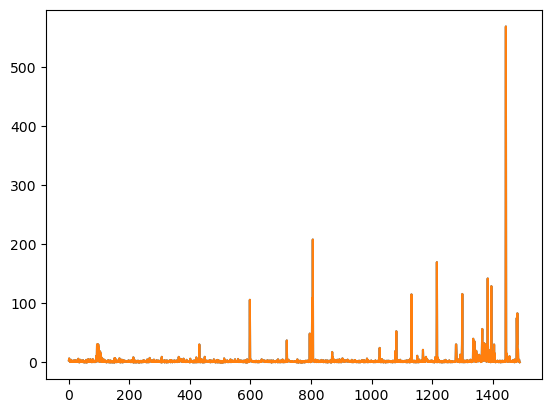

In [1375]:
## plot the timestamps (difffernces) to see if they overlay perfectly 

NIDAQ_ts_diff = np.diff(Bpod_NIDAQ_TTLS['global_timestamp'][(clock_barcode_index[0] + len(Clock_barcode)+ 1):clock_barcode_index[0] + len(Clock_barcode) + len(all_timestamps)+ 1])
behaviour_ts_diff = np.diff(all_timestamps)

plt.plot(NIDAQ_ts_diff[0::]) ## 1:: because the behaviour starts from diff between trial and first poke while ephys starts from barcode end to trial start 
plt.plot(behaviour_ts_diff[0::])


(-0.1, 0.1)

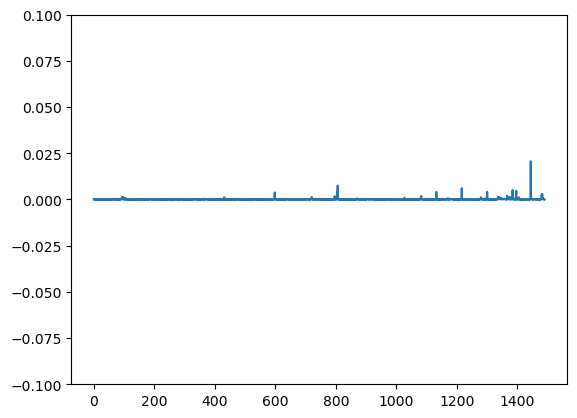

In [1376]:
## plot the difference between the two to see if there is misalingment between the two timestamp sets: 

plt.plot(NIDAQ_ts_diff- behaviour_ts_diff)
plt.ylim([-0.1, 0.1])

In [1377]:
barcode_offset = (clock_barcode_index[0] + len(Clock_barcode))

all_NIDAQ_TS = np.array(Bpod_NIDAQ_TTLS['global_timestamp'][barcode_offset::])

all_states = np.array(Bpod_NIDAQ_TTLS['state'][barcode_offset::])
up_ticks_inds = np.where(all_states == 1)
down_ticks_inds = np.where(all_states == 0)

trial_start_TS = np.unique(clock_data['Trial_Start'])
first_poke_TS = np.array(sorted(list(clock_first_poke_times)))

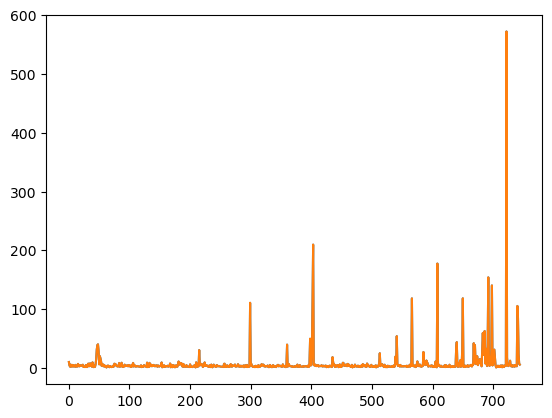

In [1378]:
## up ticks - trials start - alignment
aligned_trial_starts_ephys_TS = all_NIDAQ_TS[up_ticks_inds][0:len(trial_start_TS)]

plt.plot(np.diff(aligned_trial_starts_ephys_TS))
plt.plot(np.diff(trial_start_TS))
# plt.xlim([380, 415])
# plt.xlim([0, 40])


(-0.1, 0.1)

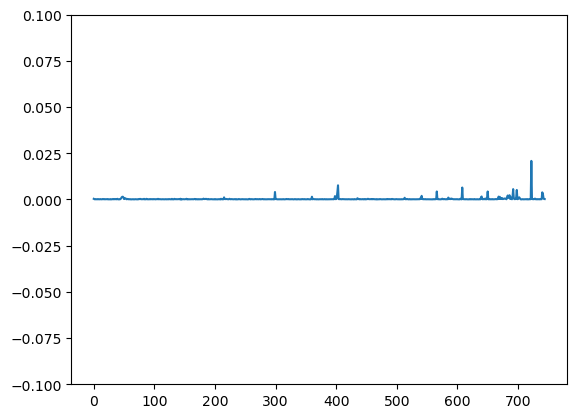

In [1379]:
plt.plot(np.diff(aligned_trial_starts_ephys_TS)-np.diff(trial_start_TS))
plt.ylim([-0.1, 0.1])

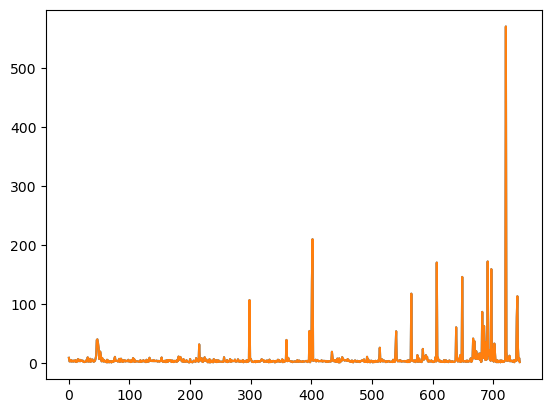

In [1380]:
## up ticks - first poke - alignment

aligned_first_poke_ephys_TS = all_NIDAQ_TS[down_ticks_inds][1:len(first_poke_TS)+1]

plt.plot(np.diff(aligned_first_poke_ephys_TS))
plt.plot(np.diff(first_poke_TS))
# plt.xlim([380, 415])
# plt.xlim([0, 40])

(-0.1, 0.1)

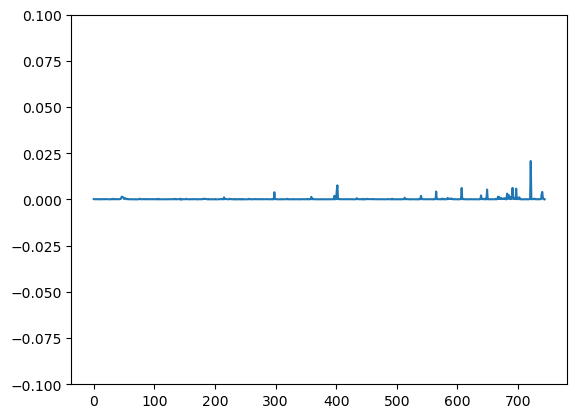

In [1381]:
plt.plot(np.diff(aligned_first_poke_ephys_TS)-np.diff(first_poke_TS))
plt.ylim([-0.1, 0.1])

In [1382]:
PokeIn_Times = list(clock_data['PokeIn_Time'])
PokeOut_Times = list(clock_data['PokeOut_Time'])
                               
trial_start = list(clock_data['Trial_Start'])
trial_id = list(clock_data['Trial_id'])
                               
PokeInTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeIn_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)
PokeOutTimes_Ephys_TS = AlignToTriggersAndFIndEphysTimestamps(PokeOut_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS,aligned_first_poke_ephys_TS)

In [1383]:
## align to and add to dataframe and then save this out: 

df_aligned_firstpoke_ephys_ts = clock_align_firstpoke_camera_timestamps(list(clock_data['Trial_id']), aligned_first_poke_ephys_TS - start_time_offset ,list(clock_data['Port']),trial_seqs)

df_aligned_trialstart_ephys_ts = align_trial_start_end_timestamps(list(clock_data['Trial_id']),aligned_trial_starts_ephys_TS)


clock_data['TrialStart_EphysTime'] = np.array(df_aligned_trialstart_ephys_ts) - start_time_offset

clock_data['FirstPoke_EphysTime'] = df_aligned_firstpoke_ephys_ts


## acount for offset 
PokeIN_EphysTime = np.array(PokeInTimes_Ephys_TS) - start_time_offset
PokeOUT_EphysTime = list(np.array(PokeOutTimes_Ephys_TS[0:-1]) - start_time_offset)  + ['NaN']

clock_data['PokeIN_EphysTime'] = PokeIN_EphysTime
clock_data['PokeOUT_EphysTime'] = PokeOUT_EphysTime


clock_data.to_csv(output_path +'/ClockPokeData_camera_ephys_aligned.csv')

In [1384]:
Port_intimes = list(clock_data['PokeIn_Time'])
Port_outtimes = list(clock_data['PokeOut_Time'])
Ports = list(clock_data['Port'])

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port times
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [1385]:
# make dataframe:
ClockTransition_df = pd.DataFrame(
    {'Trial_id' : clock_data['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Repeat_Filter':Non_Port_repeat,
     'P1_IN_Ephys_TS': PokeIN_EphysTime[0:-1],
     'P1_OUT_Ephys_TS': PokeOUT_EphysTime[0:-1],
     'P2_IN_Ephys_TS': PokeIN_EphysTime[1::],
     'P2_OUT_Ephys_TS': PokeOUT_EphysTime[1::]})

    
#Save Data
ClockTransition_df.to_csv(output_path +'/ClockTransitionData_camera_ephys_aligned.csv')

In [1386]:
16857.148907 - 12898.485168

3958.6637389999996

In [1387]:
4001.5978 - 43.0649

3958.5329

In [1388]:
clock_data

,Unnamed: 0,Trial_id,Trial_sequence,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,SIDE_Trial_Start_Camera_Time,SIDE_Trial_End_Camera_Time,SIDE_First_poke_Camera_Time,TrialStart_EphysTime,FirstPoke_EphysTime,PokeIN_EphysTime,PokeOUT_EphysTime
0,0,1,"[1, 5]",11.9939,3,14.7719,15.0600,NaN,22.4909,70.450000,80.947000,NaN,70.449625,80.946625,NaN,16792.916601,NaN,16795.694601,16795.982701
1,1,1,"[1, 5]",11.9939,2,15.3049,15.4724,NaN,22.4909,70.450000,80.947000,NaN,70.449625,80.946625,NaN,16792.916601,NaN,16796.227601,16796.395101
2,2,1,"[1, 5]",11.9939,1,15.6968,15.7166,NaN,22.4909,70.450000,80.947000,74.165000,70.449625,80.946625,74.147875,16792.916601,16796.619646,16796.619501,16796.639301
3,3,1,"[1, 5]",11.9939,1,15.7495,18.3988,NaN,22.4909,70.450000,80.947000,NaN,70.449625,80.946625,NaN,16792.916601,NaN,16796.672201,16799.321501
4,4,1,"[1, 5]",11.9939,6,18.7612,19.0241,NaN,22.4909,70.450000,80.947000,NaN,70.449625,80.946625,NaN,16792.916601,NaN,16799.683901,16799.946801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,3215,745,"[2, 6]",5932.9175,3,5936.4693,5936.5922,NaN,5939.0223,5991.918625,5998.023425,NaN,5991.904125,5998.008925,NaN,22714.056384,NaN,22717.608184,22717.731084
3216,3216,745,"[2, 6]",5932.9175,2,5937.4992,5937.5281,NaN,5939.0223,5991.918625,5998.023425,5996.499875,5991.904125,5998.008925,5996.485250,22714.056384,22718.638178,22718.638084,22718.666984
3217,3217,745,"[2, 6]",5932.9175,2,5937.5346,5938.2684,NaN,5939.0223,5991.918625,5998.023425,NaN,5991.904125,5998.008925,NaN,22714.056384,NaN,22718.673484,22719.407284
3218,3218,745,"[2, 6]",5932.9175,6,5938.6123,5938.8689,5938.6123,5939.0223,5991.918625,5998.023425,NaN,5991.904125,5998.008925,NaN,22714.056384,NaN,22719.751184,22720.007784


In [1389]:
ClockTransition_df

,Trial_id,Transition_type,Start_Port,End_Port,Start_Poke_in_time,Start_Poke_out_time,End_Poke_in_time,End_Poke_out_time,out_in_Latency,in_in_Latency,2s_Time_Filter_out_in,2s_Time_Filter_in_in,Repeat_Filter,P1_IN_Ephys_TS,P1_OUT_Ephys_TS,P2_IN_Ephys_TS,P2_OUT_Ephys_TS
0,1,32,3,2,14.7719,15.0600,15.3049,15.4724,0.2449,0.5330,1,1,1,16795.694601,16795.982701,16796.227601,16796.395101
1,1,21,2,1,15.3049,15.4724,15.6968,15.7166,0.2244,0.3919,1,1,1,16796.227601,16796.395101,16796.619501,16796.639301
2,1,11,1,1,15.6968,15.7166,15.7495,18.3988,0.0329,0.0527,1,1,0,16796.619501,16796.639301,16796.672201,16799.321501
3,1,16,1,6,15.7495,18.3988,18.7612,19.0241,0.3624,3.0117,1,0,1,16796.672201,16799.321501,16799.683901,16799.946801
4,1,61,6,1,18.7612,19.0241,19.4715,19.9082,0.4474,0.7103,1,1,1,16799.683901,16799.946801,16800.394201,16800.830901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,744,63,6,3,5932.5073,5932.9423,5936.4693,5936.5922,3.5270,3.9620,0,0,1,22713.645943,22714.080943,22717.608184,22717.731084
3215,745,32,3,2,5936.4693,5936.5922,5937.4992,5937.5281,0.9070,1.0299,1,1,1,22717.608184,22717.731084,22718.638084,22718.666984
3216,745,22,2,2,5937.4992,5937.5281,5937.5346,5938.2684,0.0065,0.0354,1,1,0,22718.638084,22718.666984,22718.673484,22719.407284
3217,745,26,2,6,5937.5346,5938.2684,5938.6123,5938.8689,0.3439,1.0777,1,1,1,22718.673484,22719.407284,22719.751184,22720.007784


In [919]:
Transition_df

,Trial_id,Transition_type,Start_Port,End_Port,Start_Poke_in_time,Start_Poke_out_time,End_Poke_in_time,End_Poke_out_time,out_in_Latency,in_in_Latency,2s_Time_Filter_out_in,2s_Time_Filter_in_in,"Port 2,3,4,5 LED intensities","Port 1,2,3,4 RewardAmount",Repeat_Filter,P1_IN_Ephys_TS,P1_OUT_Ephys_TS,P2_IN_Ephys_TS,P2_OUT_Ephys_TS
0,1,11,1,1,197.2256,197.2256,197.6548,197.6548,0.1000,0.4292,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",0,551.355162,551.684362,551.784362,551.945662
1,1,16,1,6,197.6548,197.6548,198.7452,198.7452,0.9291,1.0904,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,551.784362,551.945662,552.874914,552.990014
2,1,63,6,3,198.7452,198.7452,199.1606,199.1606,0.3003,0.4154,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,552.874914,552.990014,553.290314,553.575914
3,1,37,3,7,199.1606,199.1606,199.7247,199.7247,0.2785,0.5641,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,553.290314,553.575914,553.854414,554.401614
4,1,72,7,2,199.7247,199.7247,200.7398,200.7398,0.4679,1.0151,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,553.854414,554.401614,554.869514,554.912714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3751,413,12,1,2,2418.6903,2418.6903,2419.2014,2419.2014,0.4403,0.5111,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,2772.896417,2772.967217,2773.407517,2773.452417
3752,413,21,2,1,2419.2014,2419.2014,2419.5195,2419.5195,0.2732,0.3181,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,2773.407517,2773.452417,2773.725617,2773.753717
3753,413,16,1,6,2419.5195,2419.5195,2419.7900,2419.7900,0.2424,0.2705,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,2773.725617,2773.753717,2773.996117,2774.070017
3754,413,63,6,3,2419.7900,2419.7900,2420.1030,2420.1030,0.2391,0.3130,1,1,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",1,2773.996117,2774.070017,2774.309117,2774.319817


In [639]:
first_poke_times

array([35.5267])

Do the same again for pre and post sleep

In [631]:
clock_data =  pd.read_csv(Behav_data_path + "/PreProcessed_RawPokeData.csv") 

In [692]:
clock_data[0:50]

,Unnamed: 0,Trial_id,Trial_sequence,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,BOTTOM_Trial_Start_Camera_Time,BOTTOM_Trial_End_Camera_Time,BOTTOM_First_poke_Camera_Time,SIDE_Trial_Start_Camera_Time,SIDE_Trial_End_Camera_Time,SIDE_First_poke_Camera_Time
0,0,1,"[1, 5]",21.7872,3,21.8150,21.8239,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,1,"[1, 5]",21.7872,1,30.4902,30.5190,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,2,1,"[1, 5]",21.7872,1,30.5280,30.5974,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,3,1,"[1, 5]",21.7872,1,30.6383,33.4565,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,4,1,"[1, 5]",21.7872,1,33.8447,34.4138,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
5,5,1,"[1, 5]",21.7872,2,35.5267,35.5307,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
6,6,1,"[1, 5]",21.7872,2,35.5385,35.5470,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
7,7,1,"[1, 5]",21.7872,2,35.5518,35.5632,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
8,8,1,"[1, 5]",21.7872,5,36.3945,37.1182,36.3945,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
9,9,1,"[1, 5]",21.7872,1,37.4989,37.9606,NaN,38.4082,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [632]:
Behav_data_path + "/PreProcessed_RawPokeData.csv" 

'Z:\\projects\\sequence_squad\\data\\processed_bpod_data\\EJT149\\Preprocessed\\03_20211119_130408_Fri/PreProcessed_RawPokeData.csv'

In [ ]:
# trial start ephys timestamps
# first poke ephys timestammps 

In [612]:
align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS,list(poke_data['Port']))

['NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 554.8695144914119,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 567.0942335630842,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 574.4819664181424,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 619.3213125980876,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 647.4642838687345,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 670.6596799073957,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 673.90579080976,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 676.4679029859498,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 679.3770806886797,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 683.0802128625238,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 686.5210377575942,
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN'

In [609]:
list(poke_data['Trial_id'])

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23

In [466]:
poke_data

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,"Port 2,3,4,5 LED intensities","Port 1,2,3,4 RewardAmount",TrainingLevel,BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,BOTTOM_Trial_Start_Camera_Time,BOTTOM_Trial_End_Camera_Time,BOTTOM_First_poke_Camera_Time,SIDE_Trial_Start_Camera_Time,SIDE_Trial_End_Camera_Time,SIDE_First_poke_Camera_Time
0,0,1,196.5748,1,197.2256,197.5548,NaN,206.0924,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,1,196.5748,1,197.6548,197.8161,NaN,206.0924,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,2,1,196.5748,6,198.7452,198.8603,NaN,206.0924,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,3,1,196.5748,3,199.1606,199.4462,NaN,206.0924,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,4,1,196.5748,7,199.7247,200.2719,NaN,206.0924,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,3752,413,2417.2082,2,2419.2014,2419.2463,NaN,2420.6666,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3753,3753,413,2417.2082,1,2419.5195,2419.5476,NaN,2420.6666,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3754,3754,413,2417.2082,6,2419.7900,2419.8639,NaN,2420.6666,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3755,3755,413,2417.2082,3,2420.1030,2420.1137,NaN,2420.6666,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted 

In [ ]:

### align behvaiour events to ephys timestamps

### create spike tiem vectors 

## save out TTL, global events thingy, behavioural data + spike time vectors




In [14]:
# Save events
save_path = Path(session_path) / f"event_df__recordnode{rn}_recording{r}.pkl"
recording.events.to_pickle(save_path)
# Save new global timestamps for each continuous recording
for continuous in recording.continuous:
    save_path = Path(session_path) / f"global_timestamps__recordnode{rn}_recording{r}_{continuous.metadata['processor_id']}_{continuous.metadata['subprocessor_id']}.npz"
#                 np.savez(file=save_path, global_timestamps=continuous.global_timestamps, metadata=continuous.metadata)
return session_data

,channel,timestamp,processor_id,subprocessor_id,state,global_timestamp
0,1,1207161,113,1,1,NaN
1,1,1208411,113,1,0,NaN
2,1,1209661,113,1,1,NaN
3,1,1210911,113,1,0,NaN
4,1,1212161,113,1,1,NaN
...,...,...,...,...,...,...
84035,1,422863531,113,0,0,14095.451033
84036,1,422874996,100,0,1,14093.950999
84037,1,422889997,100,0,0,14094.450983
84038,1,422904999,100,0,1,14094.951000


In [20]:
np.unique(data.events['processor_id'])

array([100, 113], dtype=int64)

In [22]:
np.unique(data.events['subprocessor_id'])

array([0, 1], dtype=int64)

In [42]:
data.events.compute_global_timestamps()

AttributeError: 'DataFrame' object has no attribute 'compute_global_timestamps'

In [44]:
data.compute_global_timestamps()

In [46]:
data.events

,channel,timestamp,processor_id,subprocessor_id,state,global_timestamp
0,1,1207161,113,1,1,NaN
1,1,1208411,113,1,0,NaN
2,1,1209661,113,1,1,NaN
3,1,1210911,113,1,0,NaN
4,1,1212161,113,1,1,NaN
...,...,...,...,...,...,...
84035,1,422863531,113,0,0,14095.451033
84036,1,422874996,100,0,1,14093.950999
84037,1,422889997,100,0,0,14094.450983
84038,1,422904999,100,0,1,14094.951000


In [9]:
main_processor_tuple=(113, 0)
aux_processor_tuples=((113,1),(109,0))
synch_channel=1

session_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT149\Recording4\2021-11-19_13-05-19\\"

session_data = Session(str(session_path))

In [10]:
session_data = Session(str(session_path))
if len(session_data.recordnodes) != 1:
    raise ValueError("should be exactly one record node.")
if len(session_data.recordnodes[0].recordings) != 1:
    raise ValueError("Should be exactly one recording.")
for rn, recordnode in enumerate(session_data.recordnodes):
    for r, recording in enumerate(recordnode.recordings):
        # Synch
        recording.add_sync_channel(
            channel=synch_channel,
            processor_id=main_processor_tuple[0],
            subprocessor_id=main_processor_tuple[1],
            main=True,
        )
        for aux_processor in aux_processor_tuples:
            recording.add_sync_channel(
                channel=synch_channel,
                processor_id=aux_processor[0],
                subprocessor_id=aux_processor[1],
                main=False,
            )
            
            

In [11]:
        logging.debug("Computing global timestamps...")
    

In [ ]:
        recording.compute_global_timestamps()
    

In [ ]:
        logging.debug("Done.")
        # Look up timestamps in samples of main processor. Only look up non-synch channels, otherwise too many!
        main_continuous = [x for x in recording.continuous if x.metadata["processor_id"] == main_processor_tuple[0] and x.metadata["subprocessor_id"] == main_processor_tuple[1]]
        main_continuous_global_timestamps = main_continuous[0].global_timestamps
        def _look_up_main_samples(row):
            return np.argmin(np.abs(main_continuous_global_timestamps - row["global_timestamp"]))
        recording.events["global_ts_in_main_samples"] = recording.events.apply(_look_up_main_samples, axis=1)
        # Save events
        save_path = Path(session_path) / f"event_df__recordnode{rn}_recording{r}.pkl"
        recording.events.to_pickle(save_path)
        # Save new global timestamps for each continuous recording
        for continuous in recording.continuous:
            save_path = Path(session_path) / f"global_timestamps__recordnode{rn}_recording{r}_{continuous.metadata['processor_id']}_{continuous.metadata['subprocessor_id']}.npz"
            np.savez(file=save_path, global_timestamps=continuous.global_timestamps, metadata=continuous.metadata)

In [ ]:
        logging.debug("Computing global timestamps...")
        recording.compute_global_timestamps()
        logging.debug("Done.")
        # Look up timestamps in samples of main processor. Only look up non-synch channels, otherwise too many!
        main_continuous = [x for x in recording.continuous if x.metadata["processor_id"] == main_processor_tuple[0] and x.metadata["subprocessor_id"] == main_processor_tuple[1]]
        main_continuous_global_timestamps = main_continuous[0].global_timestamps
        

In [ ]:
        def _look_up_main_samples(row):
            return np.argmin(np.abs(main_continuous_global_timestamps - row["global_timestamp"]))
        recording.events["global_ts_in_main_samples"] = recording.events.apply(_look_up_main_samples, axis=1)
        # Save events
        save_path = Path(session_path) / f"event_df__recordnode{rn}_recording{r}.pkl"
        recording.events.to_pickle(save_path)
        # Save new global timestamps for each continuous recording
        for continuous in recording.continuous:
            save_path = Path(session_path) / f"global_timestamps__recordnode{rn}_recording{r}_{continuous.metadata['processor_id']}_{continuous.metadata['subprocessor_id']}.npz"
            np.savez(file=save_path, global_timestamps=continuous.global_timestamps, metadata=continuous.metadata)        
        
        

In [75]:
CuratedeSpikeTimeVectors

NameError: name 'CuratedeSpikeTimeVectors' is not defined

In [103]:
np.diff(np.array(rec.events['timestamp'])/Fs)

array([0.04166667, 0.04166667, 0.04166667, ..., 0.50003333, 0.50006667,
       0.50003333])

# Process:

In [8]:
## determine record start offset - when you press play it starts TTL clock, when you press record it starts Ephys clock, or something like that. 
sync = open(r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT149\Recording4\2021-11-19_13-05-19\Record Node 102\experiment1\recording2\\" + "sync_messages.txt", 'r')
lines = sync.readlines()
print(lines[1])
offset = int(lines[1][-14:-9])/Fs

Processor: Neuropix-PXI Id: 113 subProcessor: 0 start time: 14478717@30000Hz



In [ ]:
# load in EPhy timestamp data
Ephys_ts_raw = np.load(EphysrawTS_data_path + "timestamps.npy")
Ephys_ts_raw= Ephys_ts_raw/Fs

In [13]:
#Load in TTL timestamps
Trigger_ts_raw = np.load(Trigger_data_path+ 'timestamps.npy')
Trigger_ts_raw = Trigger_ts_raw/Fs
Ephys_ts_state = np.load(Trigger_data_path + 'channel_states.npy')
            
# load in behavioural data             
poke_data =  pd.read_csv(Behav_data_path + "/PreProcessed_RawPokeData.csv") 
# transition_data =  pd.read_csv(Behav_data_path +  "/PreProcessed_TransitionData.csv")
# Session_data =  pd.read_csv(Behav_data_path + "/PreProcessed_SessionInfo.csv")

# load in spike data and curation file:
spike_times = np.load(Processed_Ephys_data_path + 'spike_times.npy')
spike_times = (np.concatenate(spike_times))/Fs
clusters = np.load(Processed_Ephys_data_path + 'spike_clusters.npy')
spike_templates = np.load(Processed_Ephys_data_path + 'spike_templates.npy')
spike_templates = np.concatenate(spike_templates)
temps = np.load(Processed_Ephys_data_path + 'templates.npy')
winv = np.load(Processed_Ephys_data_path + 'whitening_mat_inv.npy')
y_coords = np.load(Processed_Ephys_data_path + 'channel_positions.npy')
y_coords = np.concatenate(y_coords)
Manual_Score = pd.read_csv(Processed_Ephys_data_path + 'cluster_group.tsv', sep='\t')

In [14]:
# Sort spike data into vectors that can be rasters. ie. single clusters and all spike times in ephys time 

# create spike time vectors for all clusters, adjus for start time offset:
spiketimevectors = create_spike_time_vectors(spike_times,clusters,offset)

# pull out curation scores for each cluster
Mscore = list(Manual_Score.loc[:,'group'])
clusterid = list(Manual_Score.loc[:,'cluster_id'])

# Sort these by good/bad manual clustering scores
# filter spike vectors by manual curation scores:
CuratedeSpikeTimeVectors = []
CuratedSpikeClusterIds= []
for index,ids in enumerate(clusterid):
    if Mscore[index] == 'good':
        CuratedeSpikeTimeVectors = CuratedeSpikeTimeVectors + [spiketimevectors[ids-1]]
        CuratedSpikeClusterIds = CuratedSpikeClusterIds + [ids]
        
print('Total curated clusters = ' + str(len(CuratedeSpikeTimeVectors)))

## Save this data out. 

filename = 'Curated_ClusterIds'
path_ = output_path + Animal[0] + '/'

if not os.path.isdir(path_):
    os.makedirs(path_)
with open(output_path + Animal[0] + '/' + filename, 'wb') as fp:
    pickle.dump(CuratedSpikeClusterIds,fp)
    
filename = 'CuratedUnits_SpikeTimes'
with open(output_path + Animal[0] + '/' + filename, 'wb') as fp:
    pickle.dump(CuratedeSpikeTimeVectors,fp)

Total curated clusters = 163


In [213]:
#load behavioural data:

Trial_ids = list(poke_data.loc[:,'Trial_id'])
poke_in_times = np.array(poke_data.loc[:,'PokeIn_Time'])
poke_out_times = np.array(poke_data.loc[:,'PokeOut_Time'])
Reward_Times = np.array(poke_data.loc[:,'Reward_Times'])
Port_ids = list(poke_data.loc[:,'Port'])
# Port1 = list(Session_data.loc[:,'Port1'])
Trial_start_times = list(poke_data.loc[:,'Trial_Start'])

# find trial start bpod timestamps (time point when epys timestamps move to 1)
#Find times where trial id changes, first trial poke is always at 0:
TrialStartIds = [0]
TrialStartIds= np.array(TrialStartIds + list(np.where(np.diff(Trial_ids) != 0)[0] + 1))

# find trial start timestamp
TrialStart_BpodTS = np.array(Trial_start_times)[TrialStartIds]

# find first sequence relevant poke timestamp (1st into port 2 = time point when epys timestamps move back to -1)
FirstPokeIds = [0]
FirstPokeIds= np.array(FirstPokeIds + list(np.where(np.diff(Trial_ids) != 0)[0] + 1))
# adjust so that first poke inds are for first pokes that are into port 2.
for ind,poke_id in enumerate(FirstPokeIds):
    if not np.array(Port_ids)[poke_id] == 2:
        for x in range(poke_id,len(Port_ids)):
            if np.array(Port_ids)[x] == 2:
                FirstPokeIds[ind] = x
                break
                
FirstPokeIN_BpodTS = poke_in_times[FirstPokeIds]

NameError: name 'poke_data' is not defined

In [20]:
# load in ephys timestamps:

#alignes with trial start:
TriggerStartEphysTS = Trigger_ts_raw[np.where(Ephys_ts_state == 1)]
#alignes with first poke in start port:
TriggerEndEphysTS = Trigger_ts_raw[np.where(Ephys_ts_state == -1)]

# special case for this dataset:
# TriggerStartEphysTS = TriggerStartEphysTS[0:-2]
# TriggerEndEphysTS = TriggerEndEphysTS[0:-2]

In [63]:
path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT149\Recording4\2021-11-19_13-05-19\Record Node 102\experiment1\recording2\events\NI-DAQmx-100.0\TTL_1\\"
new_ts_raw = np.load(path + "channel_states.npy")

In [64]:
new_ts_raw

array([ 1, -1,  1, ..., -1,  1, -1], dtype=int16)

In [57]:
new_ts_raw= new_ts_raw/Fs

In [53]:
np.diff(new_ts_raw)

array([0.50006667, 0.50006667, 0.50003333, ..., 0.50003333, 0.50006667,
       0.50003333])

In [32]:
new_ts_raw = np.load(niDAQ_path + "timestamps.npy")
new_ts_raw= new_ts_raw/Fs

In [46]:
sync_TS = np.load(path_new + "timestamps.npy")

In [47]:
sync_TS= sync_TS/Fs

In [48]:
sync_TS

array([  483.13336667,   483.1334    ,   483.13343333, ...,
       14097.59993333, 14097.59996667, 14097.6       ])

In [42]:
path_new = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT149\Recording4\2021-11-19_13-05-19\Record Node 102\experiment1\recording2\continuous\NI-DAQmx-100.0\\"

In [31]:
niDAQ_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT149\Recording4\2021-11-19_13-05-19\Record Node 102\experiment1\recording2\events\NI-DAQmx-100.0\TTL_1\\"

In [35]:
np.diff(new_ts_raw)[0:100]

array([0.50006667, 0.50006667, 0.50003333, 0.50006667, 0.50003333,
       0.50006667, 0.50006667, 0.50003333, 0.50006667, 0.50003333,
       0.50006667, 0.50006667, 0.50003333, 0.50006667, 0.50003333,
       0.50006667, 0.50003333, 0.50006667, 0.50006667, 0.50003333,
       0.50006667, 0.50003333, 0.50006667, 0.50006667, 0.50003333,
       0.50006667, 0.50003333, 0.50006667, 0.50006667, 0.50003333,
       0.50006667, 0.50003333, 0.50006667, 0.50003333, 0.50006667,
       0.50006667, 0.50003333, 0.50006667, 0.50003333, 0.50006667,
       0.50006667, 0.50003333, 0.50006667, 0.50003333, 0.50006667,
       0.50006667, 0.50003333, 0.50006667, 0.50003333, 0.50006667,
       0.50003333, 0.50006667, 0.50006667, 0.50003333, 0.50006667,
       0.50003333, 0.50006667, 0.50006667, 0.50003333, 0.50006667,
       0.50003333, 0.50006667, 0.50003333, 0.50006667, 0.50006667,
       0.50003333, 0.50006667, 0.50003333, 0.50006667, 0.50006667,
       0.50003333, 0.50006667, 0.50003333, 0.50006667, 0.50006

IndexError: list index out of range

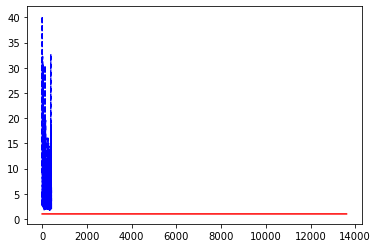

In [21]:
## check difference:



diff1 = diff(TriggerStartEphysTS)
diff2 = diff(TrialStart_BpodTS)
plt.plot(diff1, color = 'r')
plt.plot(diff2,'--',color = 'b')

abs_dif = []
for i in range(len(diff1)):
    abs_dif = abs_dif+ [diff1[i] - diff2[i]]


In [30]:
## align behaviour to ephys timestamps

PokeIn_EphysTS = AlignToTriggersAndFIndEphysTimestamps(poke_in_times,Trial_ids,TrialStart_BpodTS,FirstPokeIN_BpodTS,TriggerStartEphysTS,TriggerEndEphysTS)
# PokeIn_EphysTS = list(trialpokes_EPhysTS)
PokeOut_EphysTS = AlignToTriggersAndFIndEphysTimestamps(poke_out_times,Trial_ids,TrialStart_BpodTS,FirstPokeIN_BpodTS,TriggerStartEphysTS,TriggerEndEphysTS)
Reward_EPhysTS = AlignToTriggersAndFIndEphysTimestamps(Reward_Times,Trial_ids,TrialStart_BpodTS,FirstPokeIN_BpodTS,TriggerStartEphysTS,TriggerEndEphysTS)


poke_data_EPhys = pd.DataFrame({'Trial_ID': Trial_ids,
                                'Port': Port_ids,
                                'Poke_IN_EphysTS': PokeIn_EphysTS,
                                'Poke_OUT_EphysTS': PokeOut_EphysTS,
                               'Reward_EphysTS': Reward_EPhysTS})

# split into first and second transitions
P1_PokeIn_EphysTS,P2_PokeIn_EphysTS = Reformat_PokeEphysTS(PokeIn_EphysTS)
P1_PokeOut_EphysTS,P2_PokeOut_EphysTS = Reformat_PokeEphysTS(PokeOut_EphysTS)

#filter out transitions that are too long:
Tfilter_upper = 2 #2s
Tfilter_lower = 0 #2s

latenies = np.array(transition_data.loc[:,'Latency'])

FilteredTransiton_inds = np.where((latenies < Tfilter_upper) & (latenies > Tfilter_lower))


transitions = np.array(transition_data.loc[:,'Transition_type'])

Filtered_latenies = latenies[FilteredTransiton_inds]
Filtered_transitions = transitions[FilteredTransiton_inds]
        
Filtered_P1_PokeIn_EphysTS = P1_PokeIn_EphysTS[FilteredTransiton_inds]
Filtered_P1_PokeOut_EphysTS = P1_PokeOut_EphysTS[FilteredTransiton_inds]
Filtered_P2_PokeIn_EphysTS = P2_PokeIn_EphysTS[FilteredTransiton_inds]
Filtered_P2_PokeOut_EphysTS = P2_PokeOut_EphysTS[FilteredTransiton_inds] 

Ephys_rewardTS = np.array(Reward_EPhysTS[1::])[FilteredTransiton_inds]
Filt_Trial_ids = np.array(Trial_ids)[1::][FilteredTransiton_inds]

Filtered_transition_data_EPhys = pd.DataFrame({'Trial_IDs' : Filt_Trial_ids,
                                      'Transition': Filtered_transitions,
                                      'P1_IN_Ephys_TS': Filtered_P1_PokeIn_EphysTS,
                                      'P1_OUT_Ephys_TS': Filtered_P1_PokeOut_EphysTS,
                                      'P2_IN_Ephys_TS': Filtered_P2_PokeIn_EphysTS,
                                      'P2_OUT_Ephys_TS': Filtered_P2_PokeOut_EphysTS,
                                      'Latency': Filtered_latenies, 
                                      'RewardEphysTS': Ephys_rewardTS})

# save out  behavioural data in ephys timestamps 
Filtered_transition_data_EPhys.to_csv(output_path + Animal[0] + '/' + 'TimeFIltered_TransitionData_EPhysAligned.csv')

In [31]:
Tfilter_upper = 1000000 #2s
Tfilter_lower = 0 #2s

latenies = np.array(transition_data.loc[:,'Latency'])

FilteredTransiton_inds = np.where((latenies < Tfilter_upper) & (latenies > Tfilter_lower))


transitions = np.array(transition_data.loc[:,'Transition_type'])

Filtered_latenies = latenies[FilteredTransiton_inds]
Filtered_transitions = transitions[FilteredTransiton_inds]
        
Filtered_P1_PokeIn_EphysTS = P1_PokeIn_EphysTS[FilteredTransiton_inds]
Filtered_P1_PokeOut_EphysTS = P1_PokeOut_EphysTS[FilteredTransiton_inds]
Filtered_P2_PokeIn_EphysTS = P2_PokeIn_EphysTS[FilteredTransiton_inds]
Filtered_P2_PokeOut_EphysTS = P2_PokeOut_EphysTS[FilteredTransiton_inds] 

Ephys_rewardTS = np.array(Reward_EPhysTS[1::])[FilteredTransiton_inds]
Filt_Trial_ids = np.array(Trial_ids)[1::][FilteredTransiton_inds]


Unfiltered_transition_data_EPhys = pd.DataFrame({'Trial_IDs' : Filt_Trial_ids,
                                      'Transition': Filtered_transitions,
                                      'P1_IN_Ephys_TS': Filtered_P1_PokeIn_EphysTS,
                                      'P1_OUT_Ephys_TS': Filtered_P1_PokeOut_EphysTS,
                                      'P2_IN_Ephys_TS': Filtered_P2_PokeIn_EphysTS,
                                      'P2_OUT_Ephys_TS': Filtered_P2_PokeOut_EphysTS,
                                      'Latency': Filtered_latenies, 
                                      'RewardEphysTS': Ephys_rewardTS})
Unfiltered_transition_data_EPhys.to_csv(output_path + Animal[0] + '/' + 'Unfiltered_TransitionData_EPhysAligned.csv')

In [32]:
Filtered_transition_data_EPhys

,Trial_IDs,Transition,P1_IN_Ephys_TS,P1_OUT_Ephys_TS,P2_IN_Ephys_TS,P2_OUT_Ephys_TS,Latency,RewardEphysTS
0,1,22,38.530733,38.530833,38.530933,38.796933,0.0002,NaN
1,1,21,38.530933,38.796933,39.937533,40.320733,1.4066,NaN
2,1,16,39.937533,40.320733,40.955733,42.201733,1.0182,NaN
3,1,33,45.212300,45.212400,45.213000,45.232600,0.0007,NaN
4,1,33,45.213000,45.232600,45.281000,45.758400,0.0680,NaN
...,...,...,...,...,...,...,...,...
2519,326,16,2708.140800,2708.486300,2708.890700,2708.973400,0.7499,NaN
2520,326,66,2708.890700,2708.973400,2709.935000,2709.983700,1.0443,NaN
2521,326,61,2709.935000,2709.983700,2710.945100,2711.167400,1.0101,NaN
2522,326,33,2713.352600,2713.611800,2713.654900,2713.904400,0.3023,NaN


In [33]:
Unfiltered_transition_data_EPhys

,Trial_IDs,Transition,P1_IN_Ephys_TS,P1_OUT_Ephys_TS,P2_IN_Ephys_TS,P2_OUT_Ephys_TS,Latency,RewardEphysTS
0,1,12,36.013067,36.075567,38.530733,38.530833,2.5175,NaN
1,1,22,38.530733,38.530833,38.530933,38.796933,0.0002,NaN
2,1,21,38.530933,38.796933,39.937533,40.320733,1.4066,NaN
3,1,16,39.937533,40.320733,40.955733,42.201733,1.0182,NaN
4,1,63,40.955733,42.201733,45.212300,45.212400,4.2563,NaN
...,...,...,...,...,...,...,...,...
2807,326,66,2708.890700,2708.973400,2709.935000,2709.983700,1.0443,NaN
2808,326,61,2709.935000,2709.983700,2710.945100,2711.167400,1.0101,NaN
2809,326,13,2710.945100,2711.167400,2713.352600,2713.611800,2.4075,NaN
2810,326,33,2713.352600,2713.611800,2713.654900,2713.904400,0.3023,NaN


In [34]:
CuratedSpikeClusterIds

[2,
 5,
 7,
 8,
 14,
 16,
 18,
 19,
 22,
 23,
 24,
 25,
 26,
 32,
 38,
 39,
 40,
 43,
 45,
 49,
 53,
 54,
 56,
 58,
 60,
 63,
 64,
 65,
 66,
 80,
 89,
 97,
 101,
 103,
 107,
 109,
 113,
 123,
 124,
 136,
 137,
 139,
 144,
 145,
 146,
 147,
 148,
 149,
 155,
 158,
 161,
 176,
 178,
 192,
 195,
 197,
 198,
 199,
 201,
 203,
 204,
 205,
 211,
 214,
 215,
 216,
 226,
 232,
 237,
 238,
 240,
 242,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 254,
 255,
 256,
 263,
 268,
 269,
 270,
 274,
 276,
 277,
 278,
 279,
 280,
 281,
 284,
 285,
 287,
 290,
 294,
 297,
 305,
 306,
 330,
 332,
 333,
 336,
 337,
 338,
 346,
 348,
 350,
 353,
 355,
 360,
 365,
 366,
 368,
 376,
 377,
 393,
 397,
 398,
 400,
 401,
 402,
 407,
 415,
 418,
 424,
 426,
 430,
 431,
 432,
 434,
 436,
 439,
 441,
 443,
 446,
 447,
 448,
 450,
 451,
 452,
 454,
 456,
 464,
 467,
 468,
 472,
 477,
 479,
 487,
 488,
 490,
 491,
 492,
 493,
 499,
 507,
 535,
 536,
 543,
 544,
 549,
 554,
 560,
 571,
 572,
 575,
 577,
 579,
 591,
 605